Author: Alex Miltenberger (ammilten@stanford.edu, ammilten@gmail.com)

June, 2022

In [1]:
import sys
sys.path.append("Seismic 1D Simulation")
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import pickle as pkl

import Utils as utils
import scipy.stats as st

from scipy.constants import G, pi
import scipy.stats as st
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

np.random.seed(1)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.neighbors import KernelDensity


# ideas:
#   Customize optimizer: opt = tf.keras.optimizers.Optimizer(..) => optimizer=opt
#   x Learning rate plateau
#   x Bigger first kernel (source wavelet)
#   x Vishal tried different initializers, He initializer (Das et al.)
#   x Larger batch size (32-64)
#   Early stop to check for validation loss/overfitting
#   x validation_split=0.2 in model.fit

def custom_loss_function(y_true, y_pred):
    weights = np.array([[1,1,1,1,1,1,0]])
    yt2 = y_true 
    yp2 = y_pred 
    
    squared_difference = tf.multiply(tf.square(yt2 - yp2) , weights)
    return tf.reduce_mean(squared_difference, axis=-1)


def train_CNN(D, inputs, return_history=False, return_model=False):

    nparams = inputs.shape[1]
    ndata = D.shape[1]

    xtrain = D.reshape(D.shape[0], D.shape[1], 1)
    ytrain, ymin, ymax = utils.normalize_data(inputs)
    He_initializer=tf.keras.initializers.he_normal()

    model = Sequential()
    model.add(Conv1D(64, 32, strides=1, activation="relu", input_shape=(ndata,1), padding='same',kernel_initializer=He_initializer))
#     model.add(Conv1D(64, 16, activation="relu", padding='same',kernel_initializer=He_initializer))
    model.add(Conv1D(32, 8, strides=1, activation="relu", padding='same',kernel_initializer=He_initializer))
#     model.add(Conv1D(16, 4, activation="relu", padding='same',kernel_initializer=He_initializer))
    model.add(Conv1D(8, 2, activation="relu", padding='same',kernel_initializer=He_initializer))
    model.add(MaxPooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last"))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(.1))
    model.add(Dense(nparams, activation='linear'))
    model.compile(loss=custom_loss_function, optimizer="adam")
    model.summary()
    
    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.05, patience=20, min_lr=0.000001, verbose=1)
    ]
    
    history = model.fit(xtrain, ytrain, batch_size=64, epochs=10, verbose=1, callbacks=cbs, validation_split=0.1)
#     model.save('model_CNN')

    def MLinv(data):
        x = data.reshape(data.shape[0], data.shape[1], 1)
        return utils.unnormalize_data(model.predict(x), ymin, ymax)
    
    return MLinv, history

In [3]:
x = np.linspace(0,200,11) 

def g(p):
    
    M = utils.prepare_M(p[0,:])
    z = utils.get_z(M)
    
    out = np.zeros((p.shape[0],z.shape[0]))
    for i in range(p.shape[0]):
        M = utils.prepare_M(p[i,:])
        out[i,:] = utils.get_z(M)
        
    return out

def sample(distr, N, kind=None):
    '''
    Samples a proposal density N times
    
    distr: see code for types (this could be a class)
    N: int
    kind: type of distr
    '''
    
    if kind == 'multivariate':
        samples = distr.rvs(N)
        
    elif kind == 'list':
        samples = [distr[i].rvs(N) for i in range(len(distr))]
        samples = np.vstack(samples).T
        
    elif kind == 'kde':
        samples = distr.resample(N).T
        
    else:
        print('DID NOT RECOGNIZE TYPE')   
        
    return samples

def dimension_reduction(train_samples_d, train_samples_m, test_samples_d, project_samples_d):
    MLinv, _ = train_CNN(train_samples_d, train_samples_m)
    S_propose = MLinv(test_samples_d)
    S_project = MLinv(project_samples_d)
    
    return S_propose, S_project  

def shuffle_together(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p,:], b[p,:]

def SMC(initial_proposal, measurement_density, numIter, Nsamples, KDEsamples=None, ntrain=1000, err_cov=None):
    '''
    initial_proposal: list of scipy.stats.rv_continuous or scipy.stats.gaussian_kde
    measurement_density: scipy.stats.rv_continuous
    Niter: # of sequential iterations
    Nsamples: # samples/iteration
    KDEsamples: number of samples for KDE estimation
    '''
    
    # Initialize proposal
    proposal = initial_proposal
    proposal_type = 'list'
    
    # Sample measurement density
    d_obs_samples = sample(measurement_density, Nsamples, kind='multivariate')
    
    if KDEsamples is None:
        KDEsamples = 2000
    
    output = {
        'm_samples':[], 
        'd_samples':[], 
        'S_samples':[],
        'pca':[],
        'weights':[],
        'proposal':[],
        'd_obs_samples':[],
        'S_obs_samples':[]
    }
    
    Iter = 0
    while Iter < numIter:
        # Sampling & fowrard model
        m_prop_samples = sample(proposal, Nsamples, kind=proposal_type)
        d_prop_samples = g(m_prop_samples)
        
        factor = 5
        d_prop_samples_2 = np.tile(d_prop_samples, (factor,1))
        m_prop_samples_2 = np.tile(m_prop_samples, (factor,1))
        m2, d2 = shuffle_together(m_prop_samples_2, d_prop_samples_2)
        
        train_err = st.multivariate_normal(mean=np.zeros(d2.shape[1]), cov=err_cov).rvs(d2.shape[0])
        
        train_samples_d = d2[:ntrain*factor,:] + train_err[:ntrain*factor,:]
        train_samples_m = m2[:ntrain*factor,:]
        test_samples_d  = d2[ntrain*factor:,:] + train_err[ntrain*factor:,:]
        test_samples_m  = m2[ntrain*factor:,:]
        project_samples_d  = d_obs_samples
        S_prop_samples, S_obs_samples = dimension_reduction(train_samples_d, train_samples_m, test_samples_d, project_samples_d)
        
        # Low-dim density estimation        
        S_prop_density = st.gaussian_kde(S_prop_samples[:KDEsamples,:].T)
        S_obs_density = st.gaussian_kde(S_obs_samples[:KDEsamples,:].T)
    
#         Weights & proposal updating
        weights = S_obs_density.evaluate(S_prop_samples.T) / S_prop_density.evaluate(S_prop_samples.T)
        proposal = st.gaussian_kde(test_samples_m.T, weights=weights, bw_method='silverman')
        
        Iter += 1
        proposal_type = 'kde'
        
        output['m_samples'].append(test_samples_m)
        output['d_samples'].append(test_samples_d)
        output['S_samples'].append(S_prop_samples)
        output['weights'].append(weights)
        output['proposal'].append(proposal)
#         output['d_obs_samples'].append(d_obs_samples),
        output['S_obs_samples'].append(S_obs_samples),
        
        
    return proposal, output

def Rejection(proposal, target, N, max_factor=5, kind='kde'):
    '''
    Rejection sampling
    
    proposal: distr
    target: distr
    N: number of desired samples
    max_factor: # candidate points = N * max_factor
    kind: stupid passer variable that could be dealt with by making a distr class
    '''
    Nprop = N*max_factor
    m_proposal_samples = sample(proposal, Nprop, kind='kde')
    d_proposal_samples = g(m_proposal_samples)
    
    p_proposal_samples = target.pdf(d_proposal_samples)
    pmax = np.max(p_proposal_samples)
    p_proposal_samples = p_proposal_samples / pmax
    
    u = np.random.rand(Nprop)
    inds = p_proposal_samples > u
    
    m_samples = m_proposal_samples[inds,:]
    if m_samples.shape[0] > N:
        m_samples = m_samples[:N,:]
    if m_samples.shape[0] < N:
        print('WARNING: only found {} samples (target samples = {})'.format(m_samples.shape[0], N))
        
    acc = m_samples.shape[0] / Nprop
    
    return m_samples, acc
    


In [4]:
t = np.linspace(0, 0.792, 199) # sampling interval of 0.004 s

names = [r'$\rho_b$ (kg/m$^3$)', r'$V_b$ (m/s)', r'$\rho_l$ (kg/m$^3$)', r'$V_l$ (m/s)', r'$h$ (m)', r'$\Delta h$ (m)', r'$f_M$ (Hz)']
plot_names = [r'$\rho_b$ (kg/m$^3$)', r'$V_b$ (m/s)', r'$\rho_l$ (kg/m$^3$)', r'$V_l$ (m/s)', r'$h$ (m)', r'$\Delta h$ (m)']

In [5]:
noise = 0.025

m_true = np.array([[1980, 3300, 2410, 1825, 265, 165, 50]])

gz_obs_true = g(m_true)[0,:]

Sigma = utils.exponential_covariance(t, 1/50, noise) #Exponential covariance

# gz_obs = st.multivariate_normal(mean=gz_obs_true, cov=Sigma).rvs(1)
gz_obs = gz_obs_true


In [6]:
rhob = [1500, 2200] #uniform
Vb = [2500, 3500] #uniform
rhol = [2000,2600] #uniform
Vl = [1700, 2200] #uniform
h = [250, 500] #uniform
dh = [30, 300] #uniform
fM = [50, 50] #constant [10,75] 
    
initial_proposal = [
    st.uniform(loc = rhob[0], scale = rhob[1] - rhob[0]), 
    st.uniform(loc = Vb[0],   scale = Vb[1]   - Vb[0]), 
    st.uniform(loc = rhol[0], scale = rhol[1] - rhol[0]), 
    st.uniform(loc = Vl[0],   scale = Vl[1]   - Vl[0]), 
    st.uniform(loc = h[0],    scale = h[1]    - h[0]), 
    st.uniform(loc = dh[0],   scale = dh[1]   - dh[0]), 
    st.uniform(loc = fM[0],   scale = fM[1]   - fM[0]) 
]
    

measurement_density = st.multivariate_normal(mean=gz_obs, cov=Sigma)
Niter = 3
Nsamples = 10000
Ntrain = 5000

posterior, fit = SMC(initial_proposal, measurement_density, Niter, Nsamples, KDEsamples=Nsamples, ntrain=Ntrain, err_cov=Sigma)



Seismic 1D Simulation/Utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  pnorm = (p-pmin)/(pmax-pmin)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 199, 64)           2112      
                                                                 
 conv1d_1 (Conv1D)           (None, 199, 32)           16416     
                                                                 
 conv1d_2 (Conv1D)           (None, 199, 8)            520       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 8)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 792)               0         
                                                                 
 dense (Dense)               (None, 32)                25376     
                                                        

In [7]:
prior_samples = sample(initial_proposal, Nsamples, kind='list')
posterior_samples = sample(posterior, Nsamples, kind='kde')
final_samples, acc_rate = Rejection(posterior, measurement_density, Nsamples, max_factor=10)

obs_d = measurement_density.rvs(size=Nsamples)

nn = Nsamples
final_samples_df = pd.DataFrame(final_samples[:nn], columns=names)
prior_samples_df = pd.DataFrame(prior_samples[:nn], columns=names)
posterior_samples_df = pd.DataFrame(posterior_samples[:nn,:], columns=names)
true_df = pd.DataFrame(m_true, columns=names)

prior_data = g(prior_samples)
posterior_data = g(posterior_samples)
final_data = g(final_samples)

# Paper Figures

/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ammilten/opt/anaconda3/lib/python3.8/site-packages/seaborn/dist

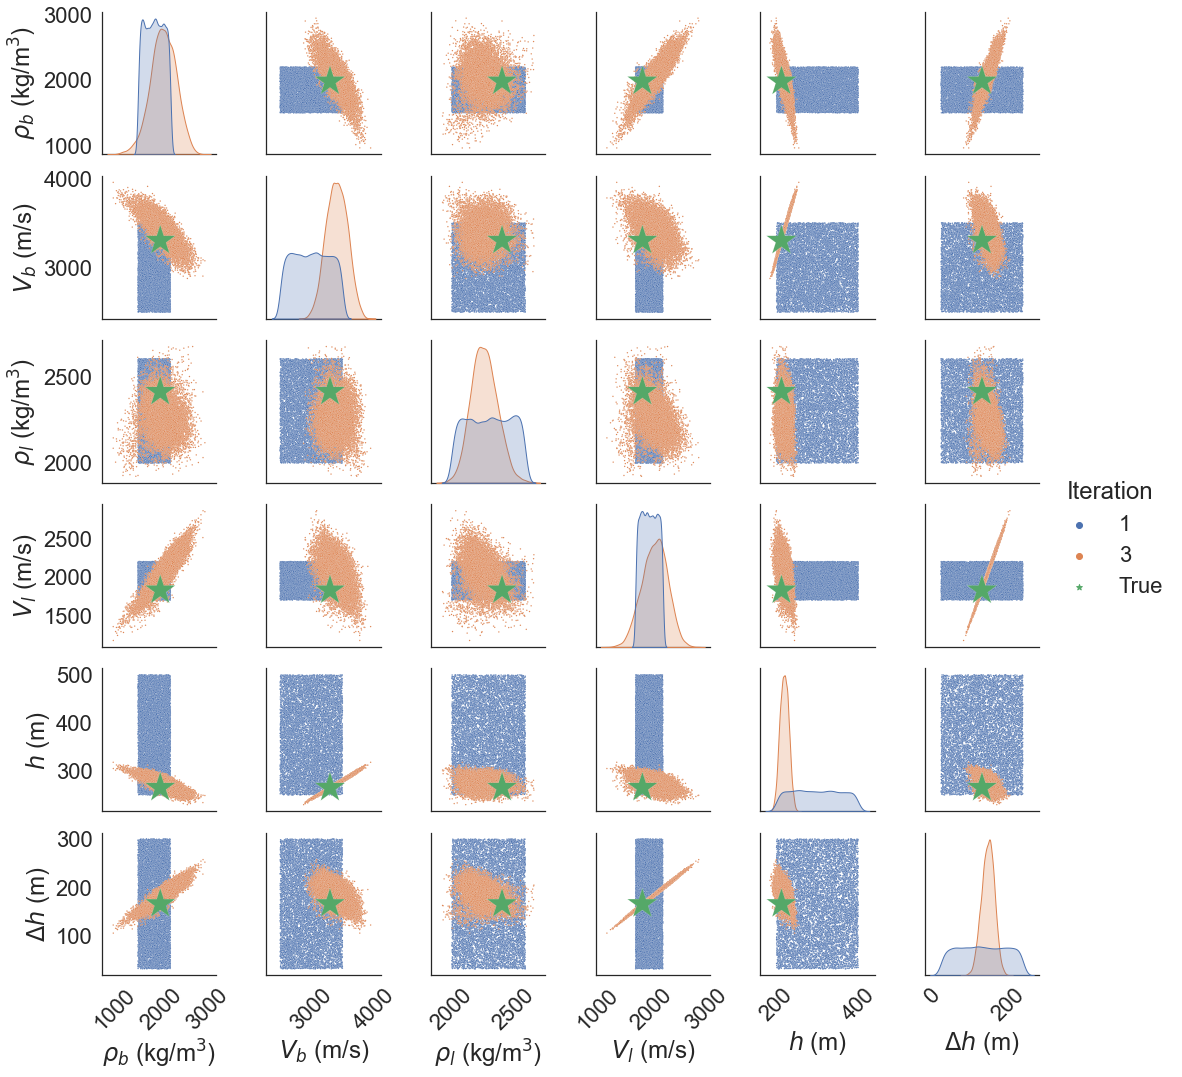

In [8]:
# Plot m-space with weights
# samples_df = pd.DataFrame(fit['m_samples'][2], columns=names)


# combined = pd.concat([
#     samples_df.assign(dataset='iteration {}'.format(t), weights=lbls2, size=(binned**3)*5, marker='o'),
# ])

combined = pd.concat([
    prior_samples_df.assign(Iteration='1', size=2, marker='o'),
    posterior_samples_df.assign(Iteration='3', size=2, marker='o'), 
#     final_samples_df.assign(distribution='Rejection', size=1, marker='o'),
    true_df.assign(Iteration='True', size=1000, marker='*')     
])
markers = {'1': 'o', '3': 'o', 'True': '*'}


sns.set(font_scale = 2)
sns.set_style(style='white')

h = sns.pairplot(
    combined[plot_names + ['Iteration']], 
    kind = 'scatter', 
#     diag_kind='kde', 
    diag_kws={'hue':combined['Iteration']},
    hue = 'Iteration',
    plot_kws={"s": combined['size']},
    markers=markers
#     hue="weights"
)

for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


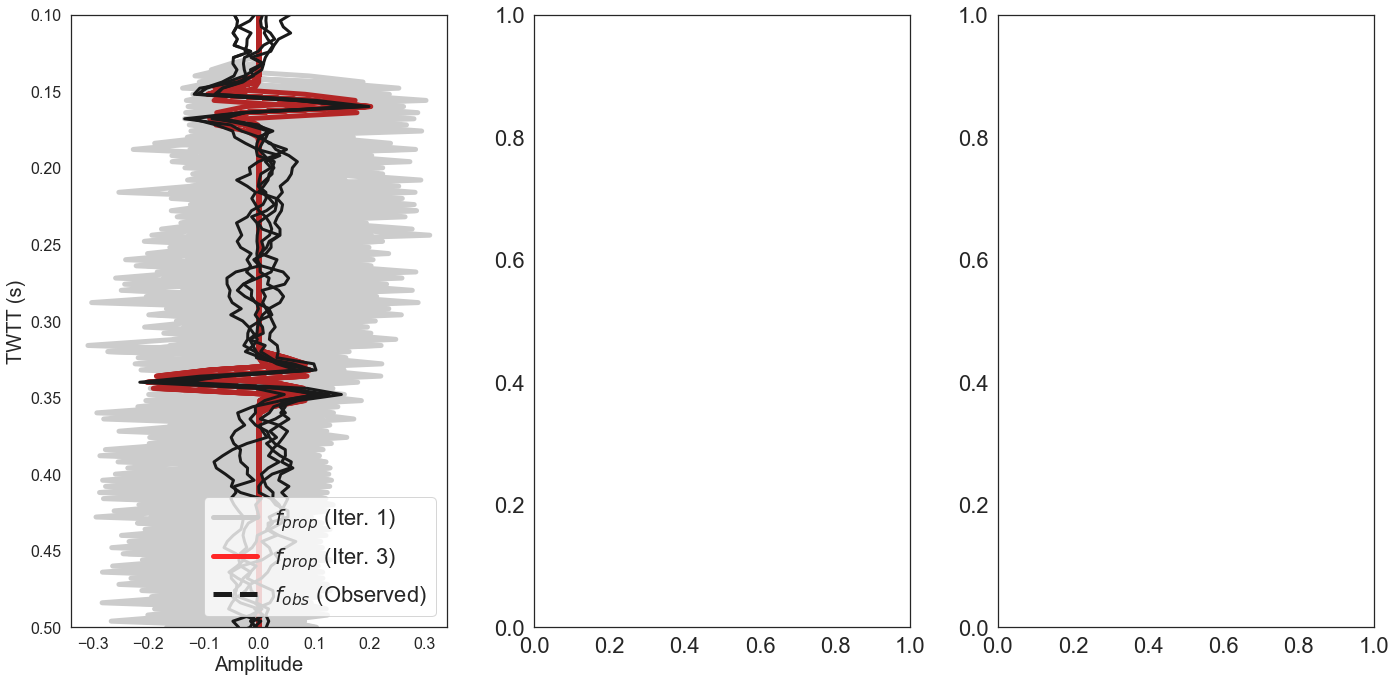

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].plot(prior_data[0,:], t, c=[.8, .8, .8], label=r'$f_{prop}$ (Iter. 1)')
axs[0].plot(posterior_data[0,:], t, c=[1, .15, .15], label=r'$f_{prop}$ (Iter. 3)') # c=[.5, .5, .5]
axs[0].plot(obs_d[0,:], t, '--k', linewidth=3, label=r'$f_{obs}$ (Observed)')

for i in range(1000):
    axs[0].plot(prior_data[i,:], t, c=[.8, .8, .8], linewidth=5)
#     axs[1].plot(D_noisy[i,:], t, c=[.8, .8, .8])
#     axs[2].plot(D_noisy[i,:], t, c=[.8, .8, .8])
    
for i in range(100):
#     plt.plot(D_noisy[post_inds[i],:], t, c=[.5, .5, .5])
    axs[0].plot(posterior_data[i,:], t, c=[0.7, .15, .15], linewidth=5)
#     axs[1].plot(D_noisy[itrain + is2[i],:], t, c=[.5, .5, .5])
#     axs[2].plot(D_noisy[itrain + is3[i],:], t, c=[.5, .5, .5])

for i in range(5):
    axs[0].plot(obs_d[i,:], t, '-k', linewidth=3)
#     axs[1].plot(Dobs2[i,:], t, '-k', linewidth=1)
#     axs[2].plot(Dobs3[i,:], t, '-k', linewidth=1)

    
axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()

axs[0].set_ylabel('TWTT (s)', fontsize=20)
axs[0].set_xlabel('Amplitude', fontsize=20)
leg = axs[0].legend(fontsize=22, loc='lower right')
for L in leg.get_lines():
    L.set_linewidth(5)
    
axs[0].tick_params(labelsize=16)
axs[0].set_ylim([0.5, 0.1])
# axs[0].set_title('Example 1', fontsize=24)

# axs[1].tick_params(labelsize=16)
# axs[1].set_xlabel('Amplitude', fontsize=20)
# axs[1].set_title('Example 2', fontsize=24)

# axs[2].tick_params(labelsize=16)
# axs[2].set_xlabel('Amplitude', fontsize=20)
# axs[2].set_title('Example 3', fontsize=24)

fig.tight_layout()

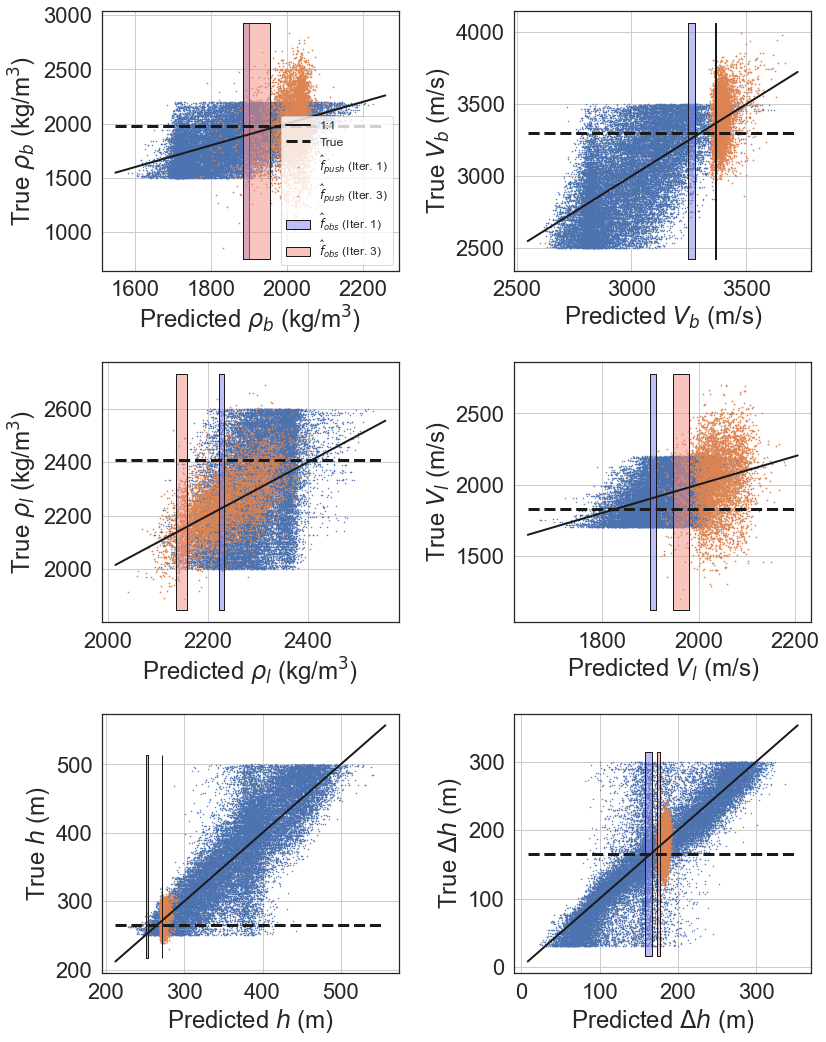

In [11]:
fi = 2
# 6 different plots [3x2]
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# x-axis: predicted
# y-axis: true
ct = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].scatter(fit['S_samples'][0][:,ct], fit['m_samples'][0][:,ct], 1, marker='.', label=r'$\hat{f}_{push}$ (Iter. 1)')
#         axs[i,j].scatter(fit['S_samples'][0][0,ct], fit['m_samples'][0][0,ct], 1, marker='.', label=r'$\hat{P}_{push}$ (Iter. 1)')
        
        axs[i,j].scatter(fit['S_samples'][fi][:5000,ct], fit['m_samples'][fi][:5000,ct], 2, marker='.', label=r'$\hat{f}_{push}$ (Iter. 3)')
#         axs[i,j].scatter(fit['S_samples'][2][0,ct], fit['m_samples'][2][0,ct], 2, marker='.', label=r'$\hat{P}_{push}$ (Iter. 3)')
        axs[i,j].set_xlabel('Predicted {}'.format(names[ct]))
        axs[i,j].set_ylabel('True {}'.format(names[ct]))
        xl = axs[i,j].get_xlim()
        yl = axs[i,j].get_ylim()
        
        axs[i,j].plot(xl, xl, '-k', linewidth=2, label='1:1')
        axs[i,j].plot(xl, [m_true[0,ct], m_true[0,ct]], '--k', linewidth=3, label='True')
        
        x_grid = np.linspace(xl[0], xl[1], 1000)
        pct = np.percentile(fit['S_obs_samples'][0][:,ct], np.array([0.05, 0.95]))
        bt = np.logical_and(pct[0] < x_grid, x_grid <= pct[1])
        axs[i,j].fill_between(x_grid, yl[0], yl[1], where=bt, facecolor=[0.5,0.5,0.95,0.5], edgecolor='k', label=r'$\hat{f}_{obs}$ (Iter. 1)')
        
        pct = np.percentile(fit['S_obs_samples'][fi][:,ct], np.array([0.05, 0.95]))
        bt = np.logical_and(pct[0] < x_grid, x_grid <= pct[1])
        axs[i,j].fill_between(x_grid, yl[0], yl[1], where=bt, facecolor=[0.95,0.55,0.5,0.5], edgecolor='k', label=r'$\hat{f}_{obs}$ (Iter. 3)')
        
        axs[i,j].grid('on')
        if ct == 0:
            axs[i,j].legend(fontsize=12, loc='lower right')
        ct += 1

    

fig.tight_layout()

7.96